# 2217014 통계학과 송채원 HW5

https://youtu.be/apT_eTKnk_I


# Problem 1

## Step 1: Preparation of data

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


G:\내 드라이브\Class\Programming_2023_Pytorch\New_2024_Chapter_5_MLE_and_GLM\HW

In [191]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv(r"/content/drive/MyDrive/EWHA/2024/2024-2/통프/HW/competition_awards_data.csv",  sep = ',', header= 0)
df.head()

,Awards,Math Score
0,0,43
1,0,38
2,0,41
3,0,33
4,0,39


In [192]:
x = torch.tensor(df['Math Score'].values, dtype=torch.float32)
n = len(x)

x_mean = torch.mean(x)
x_std = torch.std(x)
xx = (x-x_mean)/x_std

y = df['Awards'].values

ones = torch.ones([n])
X = torch.stack([ones, xx], axis=1)
Y = torch.tensor(y.reshape([n,1]), dtype=torch.float32)

dataset = TensorDataset(X,Y)
trainloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [193]:
print(X.shape, Y.shape)

torch.Size([200, 2]) torch.Size([200, 1])


In [194]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Convert the data to TensorDataset to use with DataLoader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

## Step 2: Model 1

Using the data above, we want to build the poisson regression model to predict the number of awards.

Model 1
```
Awards ~ exp(beta0 + beta1 * MathScore)
```

Answer the following questions.

1. Train the model.

2. You want to predict the number of awards for people having `Math Score = 47, 40, 80`. Calculated the predicted number of awards for these people.



### 1. Train the model.

In [195]:
beta = torch.tensor(torch.randn([2, 1]), requires_grad=True)

def forward(xx):
    temp = torch.exp(xx @ beta)
    return temp

def criterion(uhat, yy):
    m = torch.distributions.poisson.Poisson(uhat)
    temp = -torch.mean(m.log_prob(yy))
    return temp

my_optimizer = torch.optim.SGD([beta], lr=0.01)

<ipython-input-195-7941b0f94733>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.randn([2, 1]), requires_grad=True)


In [196]:
epochs = 100
history = []
n = len(trainloader.dataset)

for epoch in range(epochs):
    LOSS_sum = 0
    for xx, yy in trainloader:
        uhat = forward(xx)
        loss = criterion(uhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        my_optimizer.zero_grad()
        loss.backward()
        my_optimizer.step()
    history.append(LOSS_sum.item() / n)

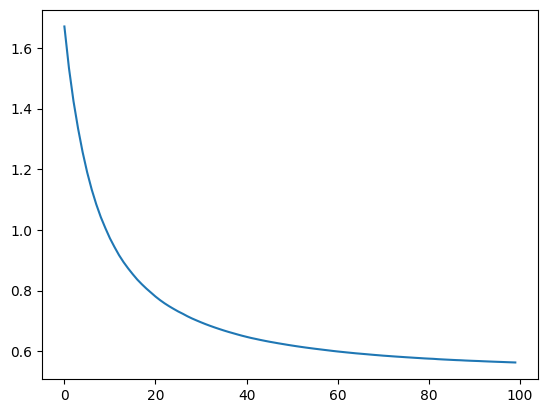

In [197]:
import matplotlib.pyplot as plt
plt.plot(history)

### 2. You want to predict the number of awards for people having `Math Score = 47, 40, 80`. Calculated the predicted number of awards for these people.

In [198]:
# Math Score = 47, 40, 80 정의
test_scores = torch.tensor([47, 40, 80], dtype=torch.float32)
test_scores = (test_scores - x_mean) / x_std
n_test = len(test_scores)
ones_test = torch.ones([n_test])
TEST = torch.stack([ones_test, test_scores], axis=1)

# 예측
predictions = forward(TEST)
predictions

tensor([[0.2638],
        [0.1727],
        [1.9441]], grad_fn=<ExpBackward0>)

## Step 3: Model 2

You are also considering the following model

Model 2
```
Awards ~ exp(beta0 + beta1 * MathScore + beta2 * MathScore**2)
```

3. Train the model.

4. You want to predict the number of awards for people having `Math Score = 47, 40, 80`. Calculated the predicted number of awards for these people.

5. Calculate the Test MSE for each model. Which model is better in terms of Test MSE?

### 데이터 준비

In [199]:
x = torch.tensor(df['Math Score'].values, dtype=torch.float32)
n = len(x)
x_mean = torch.mean(x)
x_std = torch.std(x)
xx = (x - x_mean) / x_std

x2 = x ** 2
x2_mean = torch.mean(x2)
x2_std = torch.std(x2)
xx2 = (x2 - x2_mean) / x2_std

y = df['Awards'].values

ones = torch.ones([n])
X2 = torch.stack([ones, xx, xx2], axis=1)
Y = torch.tensor(y.reshape([n,1]), dtype=torch.float32)

dataset2 = TensorDataset(X2, Y)
trainloader2 = DataLoader(dataset=dataset2, batch_size=32, shuffle=True)
print(X2.shape, Y.shape)

torch.Size([200, 3]) torch.Size([200, 1])


In [200]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)

# Convert the data to TensorDataset to use with DataLoader
train_dataset2 = TensorDataset(X_train, Y_train)
test_dataset2 = TensorDataset(X_test, Y_test)
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=32, shuffle=True)

### 3. Train the model.

In [201]:
# beta 정의 : 절편, X, X**2이므로 [3, 1]
beta2 = torch.tensor(torch.randn([3, 1]), requires_grad=True)

def forward2(xx):
    temp = torch.exp(xx @ beta2)
    return temp

def criterion(uhat, yy):
    m = torch.distributions.poisson.Poisson(uhat)
    temp = -torch.mean(m.log_prob(yy))
    return temp

my_optimizer = torch.optim.SGD([beta2], lr=0.01)

<ipython-input-201-250edc570761>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta2 = torch.tensor(torch.randn([3, 1]), requires_grad=True)


In [202]:
epochs = 100
history = []
n = len(trainloader2.dataset)

for epoch in range(epochs):
    LOSS_sum = 0
    for xx, yy in trainloader2:
        uhat = forward2(xx)
        loss = criterion(uhat, yy)
        LOSS_sum = LOSS_sum + loss * len(yy)
        my_optimizer.zero_grad()
        loss.backward()
        my_optimizer.step()
    history.append(LOSS_sum.item() / n)

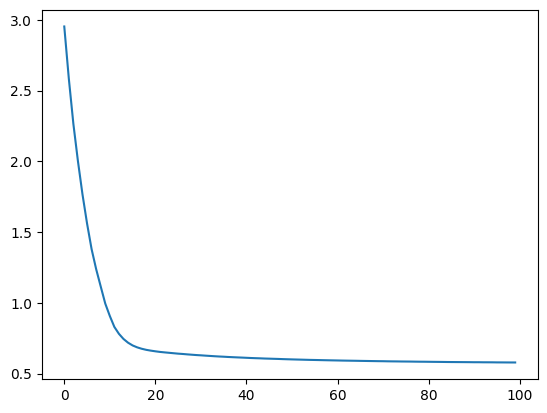

In [203]:
import matplotlib.pyplot as plt
plt.plot(history)

### 4. You want to predict the number of awards for people having `Math Score = 47, 40, 80`. Calculated the predicted number of awards for these people.

In [204]:
# Math Score = 47, 40, 80 정의
test_scores = torch.tensor([47, 40, 80], dtype=torch.float32)

test_scores_X = (test_scores - x_mean) / x_std
test_scores_X2 = (test_scores **2 - x2_mean) / x2_std

n_test = len(test_scores)
ones_test = torch.ones([n_test])
TEST = torch.stack([ones_test, test_scores_X, test_scores_X2], axis=1)

# 예측
predictions = forward2(TEST)
predictions

tensor([[0.2165],
        [0.1579],
        [1.7914]], grad_fn=<ExpBackward0>)

### 5. Calculate the Test MSE for each model. Which model is better in terms of Test MSE?

In [205]:
# Model1
test_MSE_sum1 = 0

n_test = len(test_loader.dataset)
for xx, yy in test_loader:
    uhat = forward(xx)  # Model 1의 예측 수행
    mse_sum = torch.sum((yy - uhat) ** 2)
    test_MSE_sum1 += mse_sum

test_MSE1 = test_MSE_sum1 / n_test
test_MSE1

tensor(0.0375, grad_fn=<DivBackward0>)

In [206]:
# Model2
test_MSE_sum2 = 0

n_test = len(test_loader2.dataset)
for xx, yy in test_loader2:
  uhat = forward2(xx)
  mse_sum = torch.sum((yy - uhat)**2)
  test_MSE_sum2 += mse_sum

test_MSE2 = test_MSE_sum2 / n_test
test_MSE2

tensor(0.0660, grad_fn=<DivBackward0>)

test MSE 계산 결과 Model1이 Model2보다 값이 작았다. 이를 통해 제곱항을 추가하지 않은 Model1이 더 나은 모델임을 알 수 있다.

train MSE와 달리 test MSE는 모델 복잡성을 늘린다고 무조건 MSE가 더 작아지지 않으며, 오히려 복잡한 모델은 과적합 위험 등의 이유로 더 단순한 모델인 Model1이 더 우수한 성능을 보인다고 볼 수 있다.

# Problem 3.

You are given the following data. Answer the following questions.

In [207]:
!pip install ISLP

In [208]:
import ISLP
Bikeshare = ISLP.load_data("Bikeshare")
print(Bikeshare.dtypes)
Bikeshare.head(10)

season           int64
mnth          category
day              int64
hr            category
holiday          int64
weekday          int64
workingday       int64
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
bikers           int64
dtype: object


,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0000,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0000,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0000,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0000,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0000,0,1,1
5,1,Jan,1,5,0,6,0,cloudy/misty,0.24,0.2576,0.75,0.0896,0,1,1
6,1,Jan,1,6,0,6,0,clear,0.22,0.2727,0.80,0.0000,2,0,2
7,1,Jan,1,7,0,6,0,clear,0.20,0.2576,0.86,0.0000,1,2,3
8,1,Jan,1,8,0,6,0,clear,0.24,0.2879,0.75,0.0000,1,7,8
9,1,Jan,1,9,0,6,0,clear,0.32,0.3485,0.76,0.0000,8,6,14


## Problem 3.1.

You are given Model 1
$$Y_i\sim Pois(\mu_i)$$
where
$\mu_i = {\rm exp}\left( b_0 + b_1X_{1,i}+\cdots + b_4X_{4,i}\right)$
and
$$
\begin{cases}
Y = bikers\\
X_1 = mnth\\
X_2 = hr\\
X_3 = temp\\
X_4 = weathersit\\
\end{cases}
$$

and Model 2:
$$Y_i\sim Pois(\mu_i)$$
where
$\mu_i = {\rm exp}\left( b_0 + b_1X_{1,i}+\cdots + b_5X_{5,i}\right)$
and
$$
\begin{cases}
Y = bikers\\
X_1 = mnth\\
X_2 = hr\\
X_3 = workingday\\
X_4 = temp\\
X_5 = weathersit\\
\end{cases}
$$

Cauculate $\widehat{Y}$ for the first five observations in the test data for each model.

**Caution**: For example, $X_1$ is a categorical data, which you want to use one-hot encoding. As a result, for Model 1, the expression $$\mu_i = {\rm exp}\left( b_0 + b_1X_{1,i}+\cdots + b_4X_{4,i}\right)$$ is not quite correct. This is because you have more than 4 explanatory variables due to one-hot encoding. You should modify this expression properly so that the model recognize the one-hot encoded explanatory variables.


### 3.1.1. Model1

$$Y_i\sim Pois(\mu_i)$$

$\mu_i = {\rm exp}\left( b_0 + b_1X_{1,i}+\cdots + b_4X_{4,i}\right)$
and
$$
\begin{cases}
Y = bikers\\
X_1 = mnth\\
X_2 = hr\\
X_3 = temp\\
X_4 = weathersit\\
\end{cases}
$$

In [209]:
import pandas as pd
import numpy as np

In [210]:
# 모델 1의 X : 월(mnth-범주형), 시간(hr-범주), 온도(temp), 날씨(weathersit-범주형)

# 데이터 준비
Y = Bikeshare['bikers'].values.reshape(-1, 1)

## 범주형 변수 원-핫 인코딩.
## 학습첫 번째 범주 제거하고 True/False 대신 0/1로 출력
## 회귀 모델 사용하는 경우 다중공선성 방지 위해 drop_first=True 설정하여 첫 번째 범주 제거
## 원-핫 결과는 pandas객체
X1_onehot = pd.get_dummies(Bikeshare[['mnth', 'hr', 'weathersit']], drop_first=True).astype(int)
X1_temp = pd.Series(Bikeshare['temp'].values, name='temp')

## 범주형 변수와 temp 합쳐 X1 정의
X1 = pd.concat([X1_onehot, X1_temp], axis=1)
X1

,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,mnth_Aug,mnth_Sept,mnth_Oct,mnth_Nov,...,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weathersit_cloudy/misty,weathersit_heavy rain/snow,weathersit_light rain/snow,temp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.24
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.22
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.22
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.24
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.42
8641,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.42
8642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.40
8643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.38


In [211]:
X1.shape

(8645, 38)

In [212]:
## train_test_split은 numpy 배열 혹은 pandas dataframe으로 반환
## 따라서 train_test_split후에 텐서 형태로 변환 필요
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)

X1_train = torch.tensor(X1_train.values, dtype=torch.float32)
X1_test = torch.tensor(X1_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset1 = TensorDataset(X1_train, Y_train)
test_dataset1 = TensorDataset(X1_test, Y_test)

train_loader1 = DataLoader(dataset=train_dataset1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(dataset=test_dataset1, batch_size=32, shuffle=False)

In [213]:
beta1 = torch.randn([X1.shape[1], 1]) * 0.01 #shape[1]이 X의 수
# 첫 다섯 개 값 예측 결과 차이가 너무 컸음
# 초기 값을 작은 값으로 설정하면 학습 초기에 발산할 위험을 방지할 수 있다고 함
# 따라서 randn*0.01을 통해 초기 가중치의 크기를 줄임
beta1.requires_grad = True

def forward1(X):
    return torch.exp(X @ beta1)

def criterion(uhat, y):
    m = torch.distributions.poisson.Poisson(uhat)
    return -torch.mean(m.log_prob(y))

optimizer1 = torch.optim.SGD([beta1], lr=0.01)

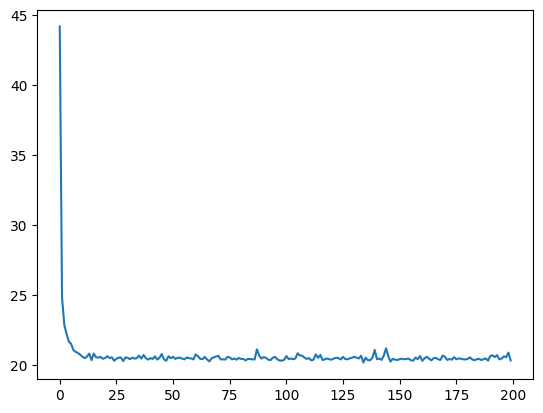

In [214]:
epochs=200
history1 = []
n = len(train_loader1.dataset)

for epoch in range(epochs):
    LOSS_sum = 0
    for xx, yy in train_loader1:
        uhat = forward1(xx)
        loss = criterion(uhat, yy)
        LOSS_sum += loss * len(yy)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    history1.append(LOSS_sum.item() / n)

plt.plot(history1)

In [215]:
# 첫 5개의 Y에 대해 예측
test = forward1(X1_test[:5]).detach().numpy()
print(Y_test[:5], "\n", test)

tensor([[ 26.],
        [171.],
        [ 54.],
        [  4.],
        [139.]]) 
 [[ 12.212284]
 [109.24619 ]
 [ 37.668816]
 [ 11.952656]
 [ 71.350365]]


### 3.1.2. Model 2
$$Y_i\sim Pois(\mu_i)$$

$\mu_i = {\rm exp}\left( b_0 + b_1X_{1,i}+\cdots + b_5X_{5,i}\right)$
and
$$
\begin{cases}
Y = bikers\\
X_1 = mnth\\
X_2 = hr\\
X_3 = workingday\\
X_4 = temp\\
X_5 = weathersit\\
\end{cases}
$$

In [216]:
# 모델 1의 X : 월(mnth-범주형), 시간(hr-범주), 온도(temp), 날씨(weathersit-범주형), workingday

# 데이터 준비
Y = Bikeshare['bikers'].values.reshape(-1, 1)

X2_onehot = pd.get_dummies(Bikeshare[['mnth', 'hr', 'weathersit']], drop_first=True).astype(int)
X2_temp_workingday = Bikeshare[['temp', 'workingday']]

## 범주형 변수와 temp 합쳐 X1 정의
X2 = pd.concat([X2_onehot, X2_temp_workingday], axis=1)
X2

,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,mnth_Aug,mnth_Sept,mnth_Oct,mnth_Nov,...,hr_19,hr_20,hr_21,hr_22,hr_23,weathersit_cloudy/misty,weathersit_heavy rain/snow,weathersit_light rain/snow,temp,workingday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.24,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.22,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.22,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.24,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0.42,0
8641,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0.42,0
8642,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.40,0
8643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.38,0


In [217]:
## train_test_split은 numpy 배열 혹은 pandas dataframe으로 반환
## 따라서 train_test_split후에 텐서 형태로 변환 필요
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)

X2_train = torch.tensor(X2_train.values, dtype=torch.float32)
X2_test = torch.tensor(X2_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset2 = TensorDataset(X2_train, Y_train)
test_dataset2 = TensorDataset(X2_test, Y_test)

train_loader2 = DataLoader(dataset=train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=32, shuffle=False)

In [218]:
beta2 = torch.randn([X2.shape[1], 1]) * 0.01
beta2.requires_grad = True

def forward2(X):
    return torch.exp(X @ beta2)

def criterion(uhat, y):
    m = torch.distributions.poisson.Poisson(uhat)
    return -torch.mean(m.log_prob(y))

optimizer2 = torch.optim.SGD([beta2], lr=0.01)

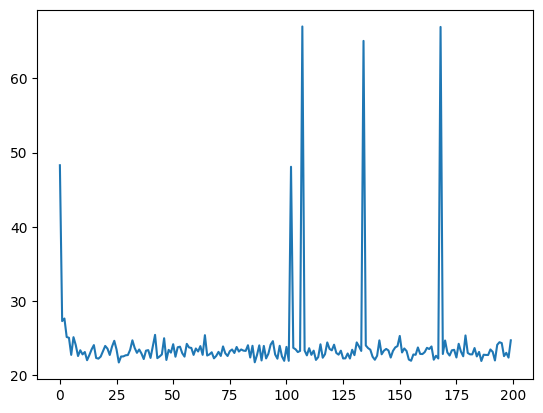

In [219]:
epochs=200
history2 = []
n = len(train_loader2.dataset)

for epoch in range(epochs):
    LOSS_sum = 0
    for xx, yy in train_loader2:
        uhat = forward2(xx)
        loss = criterion(uhat, yy)
        LOSS_sum += loss * len(yy)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
    history2.append(LOSS_sum.item() / n)

plt.plot(history2)

In [220]:
# 첫 5개의 Y에 대해 예측
test = forward2(X2_test[:5]).detach().numpy()
print(Y_test[:5], "\n", test)

tensor([[ 26.],
        [171.],
        [ 54.],
        [  4.],
        [139.]]) 
 [[ 18.2593  ]
 [158.26268 ]
 [ 48.36391 ]
 [ 15.182629]
 [ 91.80263 ]]


## Problem 3.2:

Which is better model in terms of TEST MSE?


In [221]:
# Model1
test_MSE_sum1 = 0

n_test = len(test_loader1.dataset)
for xx, yy in test_loader1:
    uhat = forward1(xx)  # Model 1의 예측 수행
    mse_sum = torch.sum((yy - uhat) ** 2)
    test_MSE_sum1 += mse_sum

test_MSE1 = test_MSE_sum1 / n_test
test_MSE1

tensor(8246.4609, grad_fn=<DivBackward0>)

In [222]:
# Model2
test_MSE_sum2 = 0

n_test = len(test_loader2.dataset)
for xx, yy in test_loader2:
    uhat = forward2(xx)  # Model 2의 예측 수행
    mse_sum = torch.sum((yy - uhat) ** 2)
    test_MSE_sum2 += mse_sum

test_MSE2 = test_MSE_sum2 / n_test
test_MSE2

tensor(6807.2778, grad_fn=<DivBackward0>)